## ***PGExplainer***


> Moduled: Accpeting the four GNNs (GCN+GAP, DGCNN, DIFFPOOL, and GIN)


---

In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-uosqignn
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-uosqignn
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 845c5cffc086c0a37dd3255d5f9219d982439efe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from statistics import mean
import torch_geometric
from torch_geometric.datasets import TUDataset
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn
from torch.autograd import graph
from typing import Any, Dict, Optional, Union
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mutag_dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
Explainability_name = 'PGExplainer'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

#File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

mutag_train_dataset = []
mutag_test_dataset = []
for index in read_training_list_indexes:
    mutag_train_dataset.append(mutag_dataset[index])
for index in read_test_list_indexes:
    mutag_test_dataset.append(mutag_dataset[index])


print(f'Number of training graphs: {len(mutag_train_dataset)}')
print(f'Number of test graphs: {len(mutag_test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [8]:
BATCH_SIZE = 64


mutag_train_dataloader = DataLoader(mutag_train_dataset, batch_size=BATCH_SIZE, shuffle=False) # important to be false
mutag_test_dataloader = DataLoader(mutag_test_dataset, batch_size=1, shuffle=False)

In [9]:
print(mutag_train_dataloader.batch_size)
batch = next(iter(mutag_train_dataloader))
print(batch.y)
print(len(mutag_train_dataloader))

64
tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])
3


In [10]:
from torch_geometric.datasets import FakeDataset

num_graphs = 100
avg_num_nodes = 20
avg_degree = 15
node_feat_dim = 13
edge_feat_dim = 0
num_classes = 3

fake_dataset = FakeDataset(num_graphs=num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=node_feat_dim,
                           edge_dim=edge_feat_dim, num_classes=num_classes,)
Explainability_name = 'PGExplainer'
Task_name = 'Graph Classification'
classifier_bias = True
DataSet_name = "Fake"
BATCH_SIZE = 10
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6

train_ratio = 0.8

fake_train_dataset = fake_dataset[:int(len(fake_dataset) * train_ratio)]
fake_test_dataset = fake_dataset[len(fake_dataset) - int(len(fake_dataset) * train_ratio):]

fake_train_dataloader = DataLoader(fake_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
fake_test_dataloader = DataLoader(fake_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(len(dataset[0].x))

NameError: name 'dataset' is not defined

In [38]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

#import GCN_plus_GAP as Graph_Network
#GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=13, hidden_dim=13, output_dim=3,
#                                       num_hid_layers=3, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
#                                       dropout_rate=classifier_dropout)

#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 13], num_classes=3, node_feat_size=13, mlp_act_fun='ReLu',
#                                    dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=17,
#                                    hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

#import DIFFPOOL as diffpool_model
#GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=13, embedding_num_block_layers=1, embedding_hid_dim=64,
#                                          new_feature_size=64, assignment_input_dim=13, assignment_num_block_layers=1,
#                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
#                                          concat_neighborhood=False, num_classes=3, Weight_Initializer=1, Bias=classifier_bias,
#                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
#                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")

import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, mlp_input_dim=7, mlp_hid_dim=11, mlp_output_dim=2, num_slp_layers=2,
                                Bias=classifier_bias, mlp_act_fun="ReLu", dropout_rate=classifier_dropout, Weight_Initializer=1,
                                joint_embeddings=False)



Model_name = GNN_Model.__class__.__name__

In [39]:
print(GNN_Model)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0-1): 2 x Linear(in_features=11, out_features=11, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0-1): 2 x BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (the_first_layer): Linear(in_features=7, out_features=11, bias=True)
  (lin1): Linear(in_features=11, out_features=11, bias=True)
  (lin2): Linear(in_features=11, out_features=2, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)


In [21]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [22]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [16]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [17]:
def train_step(data):
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in data:
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            batch_loss = loss_calculations(soft, batch_of_graphs.y)
            Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
            Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, prediction_output = GNN_Model(batch_of_graphs, None)
            Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
            batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)

        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)
            Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())
        else:
            raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [18]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index, data):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step(data)
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
        #  torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.6182
Epoch: 002, Model Loss: 0.5372
Epoch: 003, Model Loss: 0.5486
Epoch: 004, Model Loss: 0.5205
Epoch: 005, Model Loss: 0.4975
Epoch: 006, Model Loss: 0.4912
Epoch: 007, Model Loss: 0.4901
Epoch: 008, Model Loss: 0.4749
Epoch: 009, Model Loss: 0.4699
Epoch: 010, Model Loss: 0.4627
Epoch: 011, Model Loss: 0.4448
Epoch: 012, Model Loss: 0.4441
Epoch: 013, Model Loss: 0.4610
Epoch: 014, Model Loss: 0.4333
Epoch: 015, Model Loss: 0.4376
Epoch: 016, Model Loss: 0.4582
Epoch: 017, Model Loss: 0.4587
Epoch: 018, Model Loss: 0.4225
Epoch: 019, Model Loss: 0.4053
Epoch: 020, Model Loss: 0.4056
Epoch: 021, Model Loss: 0.4100
Epoch: 022, Model Loss: 0.4030
Epoch: 023, Model Loss: 0.3808
Epoch: 024, Model Loss: 0.3694
Epoch: 025, Model Loss: 0.3748
Epoch: 026, Model Loss: 0.3649
Epoch: 027, Model Loss: 0.3748
Epoch: 028, Model Loss: 0.3504
Epoch: 029, Model Loss: 0.3696
Epoch: 030, Model Loss: 0.3596
Epoch: 031, Model Loss: 0.3775
Epoch: 032, Model Loss: 0.3481
Epoch: 0

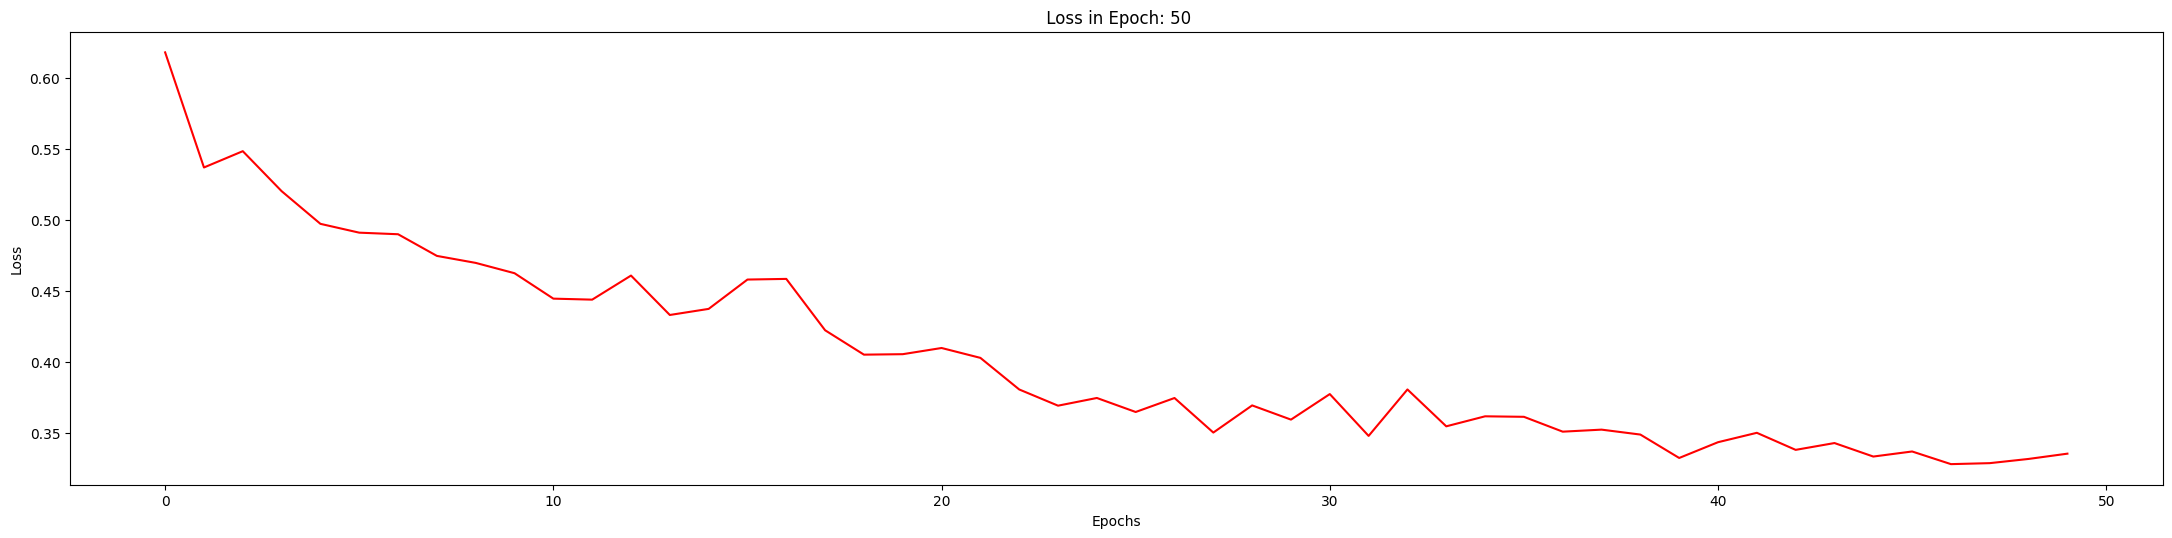

Epoch: 051, Model Loss: 0.3248
Epoch: 052, Model Loss: 0.3330
Epoch: 053, Model Loss: 0.3322
Epoch: 054, Model Loss: 0.3375
Epoch: 055, Model Loss: 0.3303
Epoch: 056, Model Loss: 0.3308
Epoch: 057, Model Loss: 0.3362
Epoch: 058, Model Loss: 0.3381
Epoch: 059, Model Loss: 0.3311
Epoch: 060, Model Loss: 0.3335
Epoch: 061, Model Loss: 0.3260
Epoch: 062, Model Loss: 0.3312
Epoch: 063, Model Loss: 0.3339
Epoch: 064, Model Loss: 0.3275
Epoch: 065, Model Loss: 0.3251
Epoch: 066, Model Loss: 0.3246
Epoch: 067, Model Loss: 0.3291
Epoch: 068, Model Loss: 0.3282
Epoch: 069, Model Loss: 0.3256
Epoch: 070, Model Loss: 0.3319
Epoch: 071, Model Loss: 0.3224
Epoch: 072, Model Loss: 0.3280
Epoch: 073, Model Loss: 0.3227
Epoch: 074, Model Loss: 0.3262
Epoch: 075, Model Loss: 0.3289
Epoch: 076, Model Loss: 0.3212
Epoch: 077, Model Loss: 0.3245
Epoch: 078, Model Loss: 0.3232
Epoch: 079, Model Loss: 0.3292
Epoch: 080, Model Loss: 0.3292
Epoch: 081, Model Loss: 0.3243
Epoch: 082, Model Loss: 0.3263
Epoch: 0

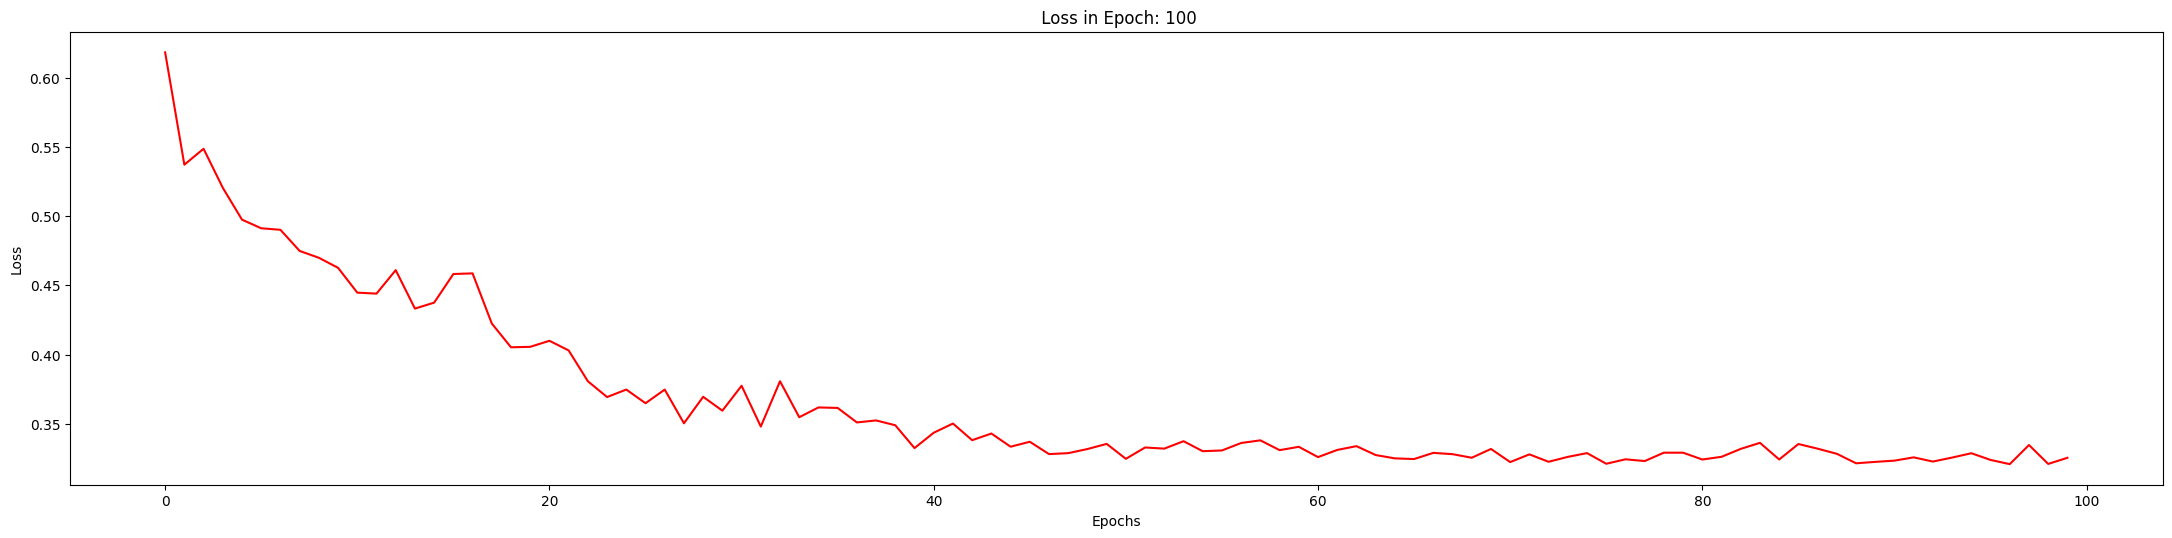

Epoch: 101, Model Loss: 0.3296
Epoch: 102, Model Loss: 0.3257
Epoch: 103, Model Loss: 0.3241
Epoch: 104, Model Loss: 0.3219
Epoch: 105, Model Loss: 0.3211
Epoch: 106, Model Loss: 0.3209
Epoch: 107, Model Loss: 0.3202
Epoch: 108, Model Loss: 0.3208
Epoch: 109, Model Loss: 0.3228
Epoch: 110, Model Loss: 0.3235
Epoch: 111, Model Loss: 0.3236
Epoch: 112, Model Loss: 0.3422
Epoch: 113, Model Loss: 0.3622
Epoch: 114, Model Loss: 0.3427
Epoch: 115, Model Loss: 0.3376
Epoch: 116, Model Loss: 0.3449
Epoch: 117, Model Loss: 0.3409
Epoch: 118, Model Loss: 0.3362
Epoch: 119, Model Loss: 0.3314
Epoch: 120, Model Loss: 0.3415
Epoch: 121, Model Loss: 0.3475
Epoch: 122, Model Loss: 0.3304
Epoch: 123, Model Loss: 0.3234
Epoch: 124, Model Loss: 0.3257
Epoch: 125, Model Loss: 0.3218
Epoch: 126, Model Loss: 0.3228
Epoch: 127, Model Loss: 0.3252
Epoch: 128, Model Loss: 0.3250
Epoch: 129, Model Loss: 0.3261
Epoch: 130, Model Loss: 0.3231
Epoch: 131, Model Loss: 0.3460
Epoch: 132, Model Loss: 0.3460
Epoch: 1

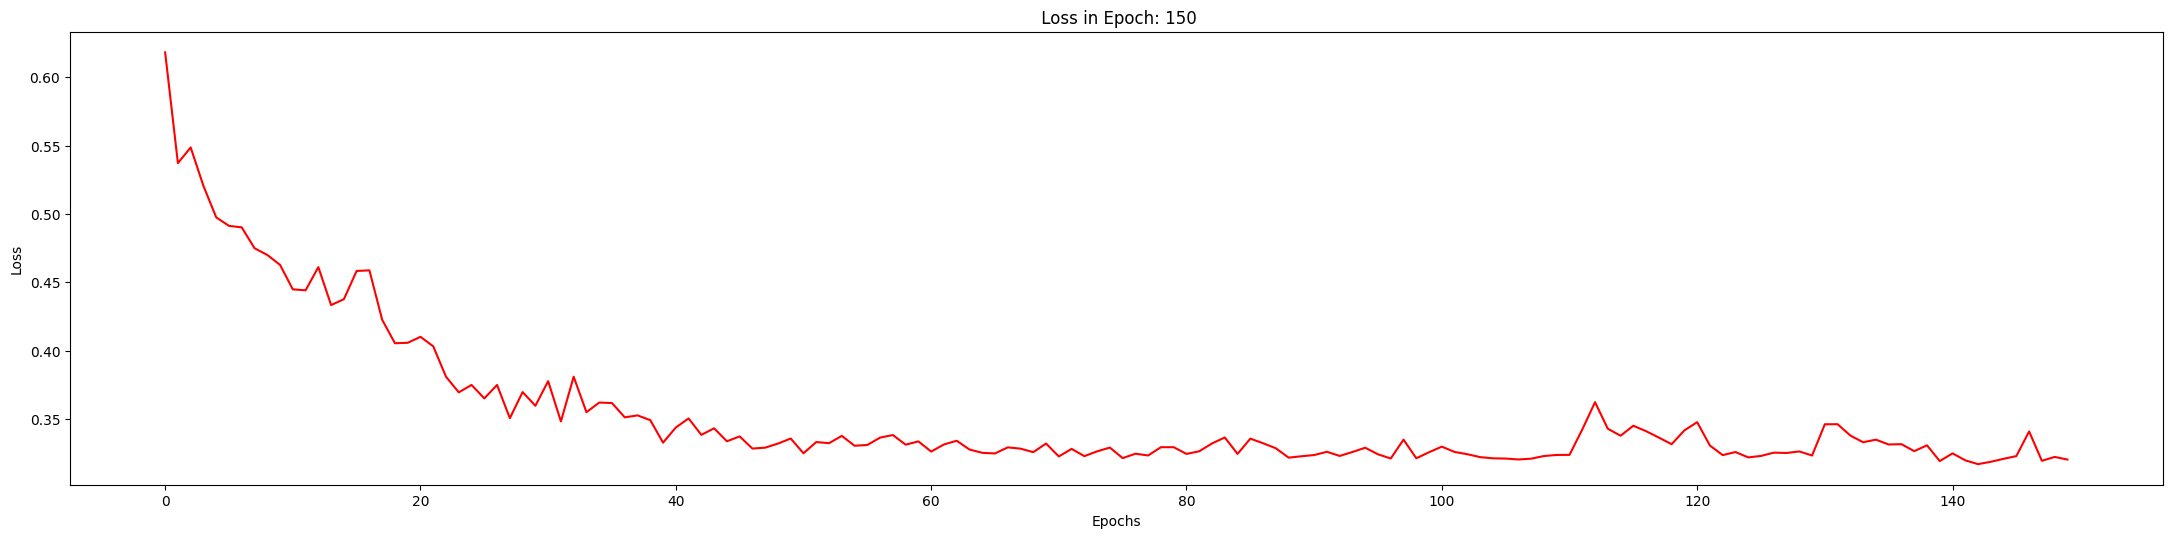

Epoch: 151, Model Loss: 0.3245
Epoch: 152, Model Loss: 0.3211
Epoch: 153, Model Loss: 0.3223
Epoch: 154, Model Loss: 0.3146
Epoch: 155, Model Loss: 0.3144
Epoch: 156, Model Loss: 0.3194
Epoch: 157, Model Loss: 0.3174
Epoch: 158, Model Loss: 0.3190
Epoch: 159, Model Loss: 0.3353
Epoch: 160, Model Loss: 0.3210
Epoch: 161, Model Loss: 0.3240
Epoch: 162, Model Loss: 0.3145
Epoch: 163, Model Loss: 0.3157
Epoch: 164, Model Loss: 0.3151
Epoch: 165, Model Loss: 0.3169
Epoch: 166, Model Loss: 0.3209
Epoch: 167, Model Loss: 0.3143
Epoch: 168, Model Loss: 0.3165
Epoch: 169, Model Loss: 0.3240
Epoch: 170, Model Loss: 0.3144
Epoch: 171, Model Loss: 0.3148
Epoch: 172, Model Loss: 0.3143
Epoch: 173, Model Loss: 0.3138
Epoch: 174, Model Loss: 0.3277
Epoch: 175, Model Loss: 0.3158
Epoch: 176, Model Loss: 0.3147
Epoch: 177, Model Loss: 0.3143
Epoch: 178, Model Loss: 0.3145
Epoch: 179, Model Loss: 0.3145
Epoch: 180, Model Loss: 0.3140
Epoch: 181, Model Loss: 0.3137
Epoch: 182, Model Loss: 0.3141
Epoch: 1

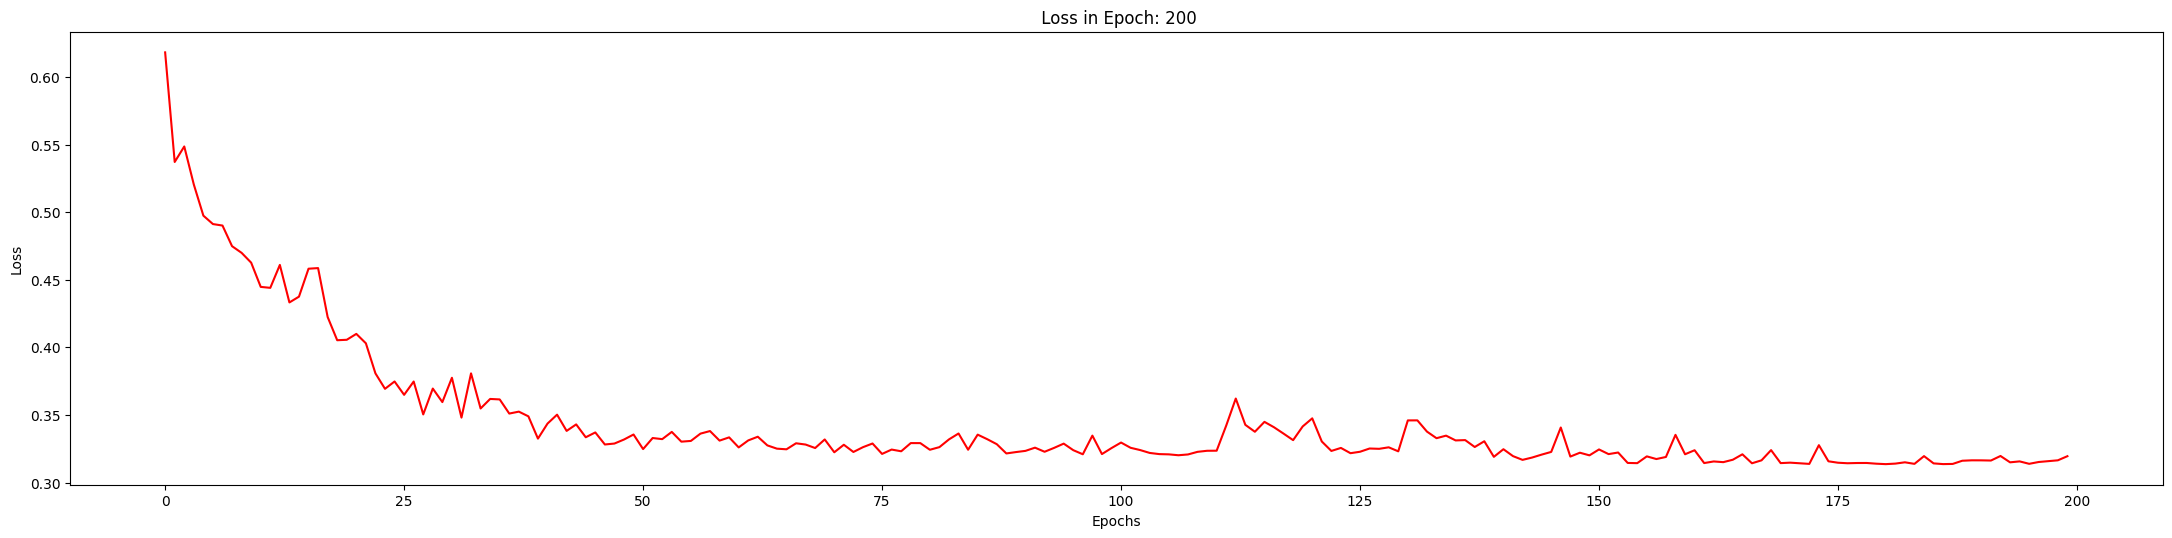

Epoch: 201, Model Loss: 0.3156
Epoch: 202, Model Loss: 0.3196
Epoch: 203, Model Loss: 0.3140
Epoch: 204, Model Loss: 0.3163
Epoch: 205, Model Loss: 0.3143
Epoch: 206, Model Loss: 0.3138
Epoch: 207, Model Loss: 0.3166
Epoch: 208, Model Loss: 0.3139
Epoch: 209, Model Loss: 0.3155
Epoch: 210, Model Loss: 0.3144
Epoch: 211, Model Loss: 0.3145
Epoch: 212, Model Loss: 0.3137
Epoch: 213, Model Loss: 0.3135
Epoch: 214, Model Loss: 0.3145
Epoch: 215, Model Loss: 0.3136
Epoch: 216, Model Loss: 0.3139
Epoch: 217, Model Loss: 0.3136
Epoch: 218, Model Loss: 0.3140
Epoch: 219, Model Loss: 0.3140
Epoch: 220, Model Loss: 0.3134
Epoch: 221, Model Loss: 0.3136
Epoch: 222, Model Loss: 0.3144
Epoch: 223, Model Loss: 0.3135
Epoch: 224, Model Loss: 0.3155
Epoch: 225, Model Loss: 0.3140
Epoch: 226, Model Loss: 0.3134
Epoch: 227, Model Loss: 0.3134
Epoch: 228, Model Loss: 0.3134
Epoch: 229, Model Loss: 0.3135
Epoch: 230, Model Loss: 0.3155
Epoch: 231, Model Loss: 0.3139
Epoch: 232, Model Loss: 0.3163
Epoch: 2

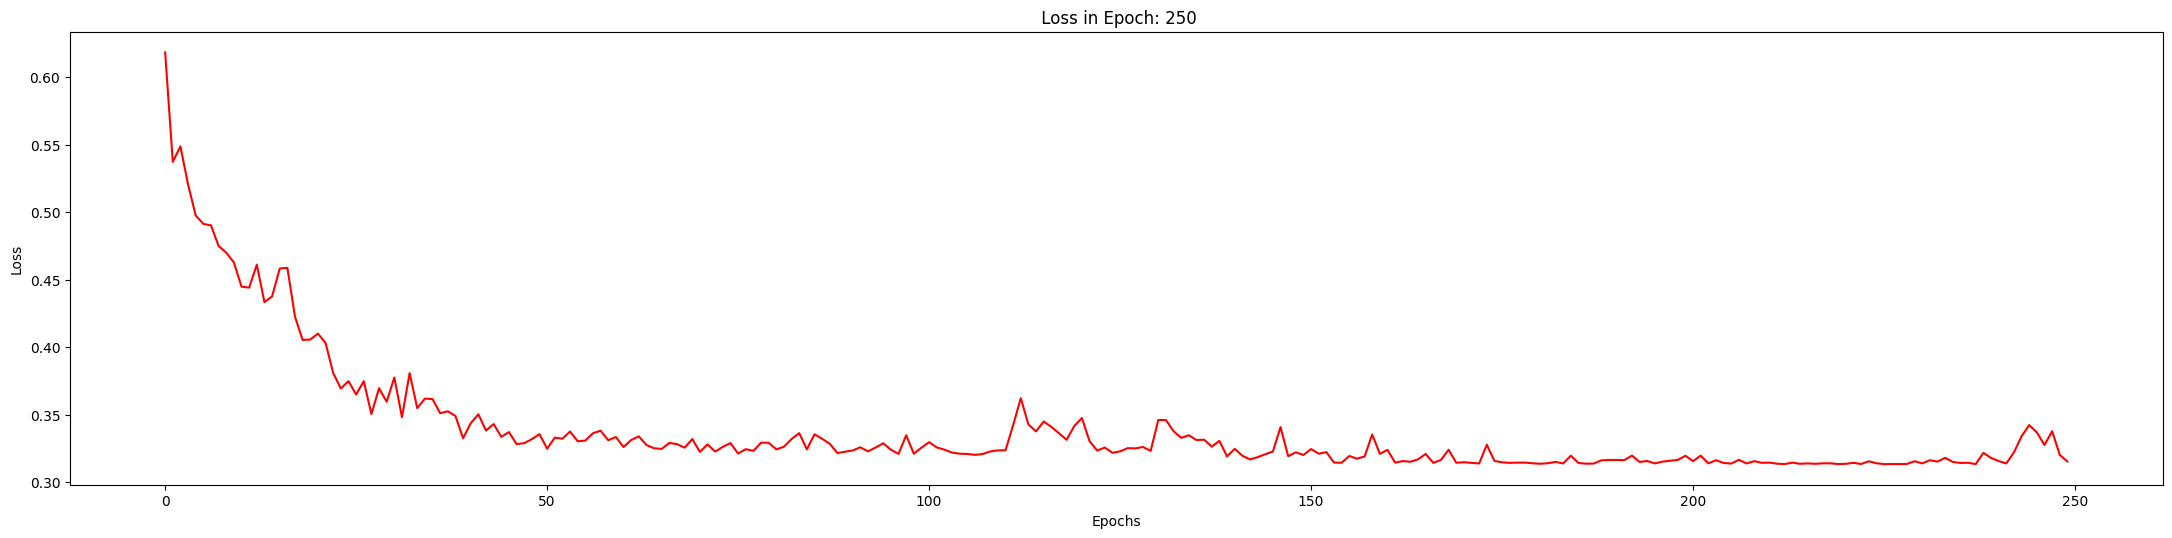

Epoch: 251, Model Loss: 0.3172
Epoch: 252, Model Loss: 0.3197
Epoch: 253, Model Loss: 0.3145
Epoch: 254, Model Loss: 0.3182
Epoch: 255, Model Loss: 0.3138
Epoch: 256, Model Loss: 0.3189
Epoch: 257, Model Loss: 0.3143
Epoch: 258, Model Loss: 0.3171
Epoch: 259, Model Loss: 0.3259
Epoch: 260, Model Loss: 0.3155
Epoch: 261, Model Loss: 0.3137
Epoch: 262, Model Loss: 0.3153
Epoch: 263, Model Loss: 0.3202
Epoch: 264, Model Loss: 0.3173
Epoch: 265, Model Loss: 0.3169
Epoch: 266, Model Loss: 0.3145
Epoch: 267, Model Loss: 0.3150
Epoch: 268, Model Loss: 0.3201
Epoch: 269, Model Loss: 0.3197
Epoch: 270, Model Loss: 0.3294
Epoch: 271, Model Loss: 0.3141
Epoch: 272, Model Loss: 0.3174
Epoch: 273, Model Loss: 0.3173
Epoch: 274, Model Loss: 0.3167
Epoch: 275, Model Loss: 0.3152
Epoch: 276, Model Loss: 0.3173
Epoch: 277, Model Loss: 0.3214
Epoch: 278, Model Loss: 0.3150
Epoch: 279, Model Loss: 0.3153
Epoch: 280, Model Loss: 0.3138
Epoch: 281, Model Loss: 0.3137
Epoch: 282, Model Loss: 0.3159
Epoch: 2

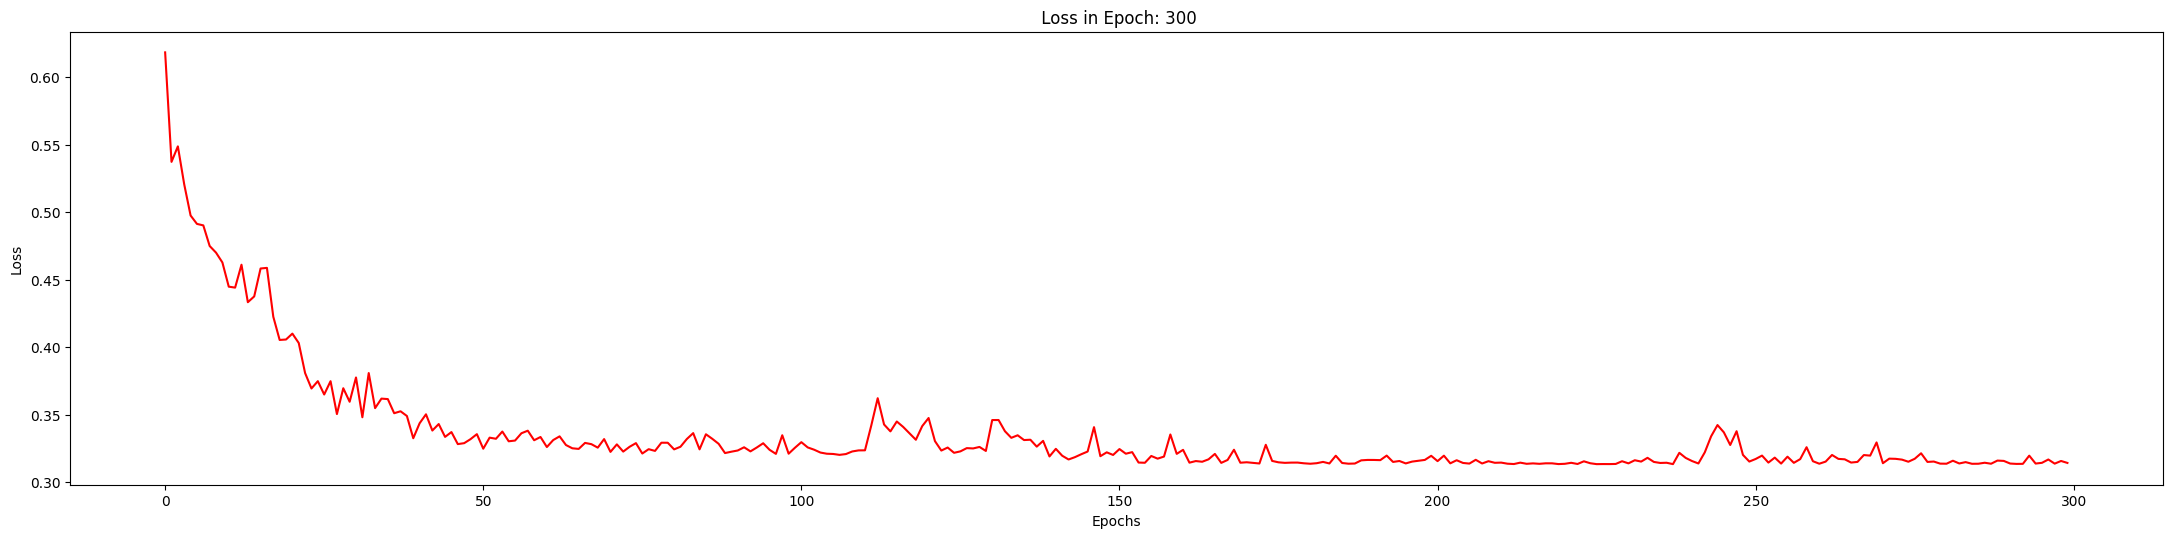

In [24]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index, mutag_train_dataloader)

In [ ]:

class PGExplainer:
    coeffs = {'edge_size': 0.05,
              'edge_ent': 1.0,
              'temp': [5.0, 2.0],
              'bias': 0.0,
              }
    def __init__(self, GNN_Model, explainer_save_index, Exp_Epoch, Exp_lr, node_feat_dim):

        self.GNN_Model = GNN_Model
        self.node_feat_dim = node_feat_dim
        self.explainer_lr = Exp_lr
        self.explainer_hid_dim = 64
        self.pgexp_mlp = Sequential(Linear(self.node_feat_dim * 2, self.explainer_hid_dim), ReLU(), Linear(self.explainer_hid_dim, 1))
        self.pgexp_mlp_optimizer = torch.optim.Adam(self.pgexp_mlp.parameters(), lr=self.explainer_lr)
        self.explainer_epochs = Exp_Epoch
        self.criterion = F.binary_cross_entropy_with_logits
        self.explainer_save_index = explainer_save_index
        self.Explainability_name = 'PGExplainer'
        self.Task_name = 'Graph Classification'


    def explainer_loss(self, By_Perturbation_predicted_label, predicted_label):
        loss_per_epoch = self.criterion(By_Perturbation_predicted_label, predicted_label)
        return loss_per_epoch


    def train_step_explainer(self, merged_embeddings_list_batchs, GNN_Model, your_dataset, temperature, GNN_Model_preds_NOT_MASKED, target_class):

        self.pgexp_mlp.train()
        self.pgexp_mlp.zero_grad()
        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):

            explaier_outputs = self.pgexp_mlp(batched_merged_embeddings).view(-1)
            edge_mask = self.binary_concrete(explaier_outputs, temperature)

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                self.apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_MASKED = self.GNN_Model(batched_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_MASKED = self.GNN_Model(batched_graphs, edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, soft_MASKED = self.GNN_Model(batched_graphs, edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = self.GNN_Model(batched_graphs, edge_mask.tolist())


            batch_loss = self.explainer_loss(soft_MASKED.detach()[:,target_class].to(torch.float32), batched_preds_NOT_MASKED.detach()[:,target_class].to(torch.float32))

            batch_loss.requires_grad = True
            batch_loss.backward(retain_graph=True)
            self.pgexp_mlp_optimizer.step()

        return edge_mask

    def train_explainer(self, GNN_Model, your_dataset, target_class):
        edge_masks_per_epoch = []
        #self.clear_masks(GNN_Model)
        merged_embeddings_list = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        for batch_of_graphs in your_dataset:

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)


        for epoch in range(self.explainer_epochs):
            print("Epoch: ", epoch)
            temperature = self.compute_temp(epoch)
            edge_mask = self.train_step_explainer(merged_embeddings_list, GNN_Model, your_dataset, temperature, GNN_Model_preds_NOT_MASKED, target_class)
            edge_masks_per_epoch.append(edge_mask)


            if (epoch + 1) == self.explainer_save_index:
                torch.save({'epoch': epoch+1, 'model_state_dict': self.pgexp_mlp.state_dict(), 'optimizer_state_dict': self.pgexp_mlp_optimizer.state_dict()}, "/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.GNN_Model.__class__.__name__) + "_Model_classifier_PGExplainer_MLP_" + str(epoch + 1) + "_epochs_" + str(target_class) + ".pt")
        self.clear_masks(GNN_Model)

    def test_explainer(self, GNN_Model, your_dataset, pgexp_mlp):
        predicted_labels_MASKED = []
        edge_masks = []
        merged_embeddings_list_batchs = self.get_merged_embeddings(GNN_Model, your_dataset)
        GNN_Model_preds_NOT_MASKED = []
        pgexp_mlp.eval()
        for batch_of_graphs in your_dataset:

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_NOT_MASKED = self.GNN_Model(batch_of_graphs, None)
            GNN_Model_preds_NOT_MASKED.append(soft_NOT_MASKED)

        for batched_merged_embeddings, batched_preds_NOT_MASKED, batched_graphs in zip(merged_embeddings_list_batchs, GNN_Model_preds_NOT_MASKED, your_dataset):
            explaier_outputs = pgexp_mlp(batched_merged_embeddings).view(-1)

            temperature = 1
            edge_mask = self.binary_concrete(explaier_outputs, temperature)
            edge_masks.append(edge_mask)

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                self.apply_masks(GNN_Model, edge_mask, batched_graphs.edge_index, apply_sigmoid=True)

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft_MASKED = self.GNN_Model(batched_graphs)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft_MASKED = self.GNN_Model(batched_graphs, edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, soft_MASKED = self.GNN_Model(batched_graphs, edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft_MASKED = self.GNN_Model(batched_graphs, edge_mask.tolist())

            predicted_labels_MASKED.append(torch.squeeze(soft_MASKED.argmax(dim=1)).tolist())
        self.clear_masks(GNN_Model)
        return predicted_labels_MASKED, edge_masks

    def apply_masks(self, model, mask, edge_index, apply_sigmoid):
        loop_mask = edge_index[0] != edge_index[1]

        for module in model.modules():
            if isinstance(module, MessagePassing):

                if (not isinstance(mask, Parameter)
                        and '_edge_mask' in module._parameters):
                    mask = Parameter(mask)

                module.explain = True
                module._edge_mask = mask
                module._loop_mask = loop_mask
                module._apply_sigmoid = apply_sigmoid
                #print(module._edge_mask)

    def clear_masks(self, model):

        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.explain = False
                module._edge_mask = None
                module._loop_mask = None
                module._apply_sigmoid = True
        return module

    def batch_handler_for_embeddings(self, batched_graphs, new_embeddings):
        unpaded_data = []
        #if batched_graphs.batch is not None:
        #    graph_sizes = [batched_graphs[i].x.size()[1] for i in range(len(batched_graphs))]
        #else:
        #    graph_sizes = [len(batched_graphs.x)]

        #for i, graph in enumerate(new_embeddings):
        #    unpaded_data.append(graph[:graph_sizes[i]])
        #new_graph_embeddings_merged = torch.cat(unpaded_data, dim=0)
        for i, graph in enumerate(new_embeddings):
            unpaded_data.append(graph)
        new_graph_embeddings_merged = torch.cat(unpaded_data, dim=0)
        return new_graph_embeddings_merged

    def get_merged_embeddings(self, GNN_Model, your_dataset):
        new_embeddings_list = []
        merged_embeddings_list = []
        for batched_graphs in your_dataset:
            new_graph_by_masks = deepcopy(batched_graphs.detach())

            new_embeddings, GNN_Model_explain_predicted_labels = self.get_hopped_embeddings(GNN_Model, new_graph_by_masks)
            #print("new_embeddings: ", new_embeddings.size())
            #print("batched_graphs: ", batched_graphs.x.size())
            new_embeddings_list.append(new_embeddings)
            if len(new_embeddings.size()) == 3:
                new_embeddings = self.batch_handler_for_embeddings(batched_graphs, new_embeddings)
                #print("size is batch")

            merged_embeddings = self.edge_embeddings(new_embeddings, new_graph_by_masks.edge_index)

            merged_embeddings_list.append(merged_embeddings)

        return merged_embeddings_list


    def edge_embeddings(self, batched_embedding, edge_index):
        Zs = [batched_embedding[edge_index[0]], batched_embedding[edge_index[1]]]
        return torch.cat(Zs, dim=-1)

    def get_hopped_embeddings(self, GNN_Model, batch_of_graphs):
        GNN_Model.eval()

        if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = self.GNN_Model(batch_of_graphs)
            return Output_of_Hidden_Layers[-1], soft.argmax(dim=1)

        elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = self.GNN_Model(batch_of_graphs, None)
            return final_GNN_layer_output, soft.argmax(dim=1)

        elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, soft = self.GNN_Model(batch_of_graphs, None)
            return batch_of_graphs.x, soft.argmax(dim=1)

        elif self.GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = self.GNN_Model(batch_of_graphs, None)
            return torch.squeeze(mlps_output_embeds[-1], dim=0), soft.argmax(dim=1)



    def compute_temp(self, epoch):
        temp = self.coeffs['temp']
        return temp[0] * pow(temp[1] / temp[0], epoch / self.explainer_epochs)

    def binary_concrete(self, explaier_outputs, temperature):
        bias = self.coeffs['bias']
        eps = (1 - 2 * bias) * torch.rand_like(explaier_outputs) + bias
        return torch.sigmoid((eps.log() - (1 - eps).log() + explaier_outputs) / temperature)
    def load_explainer_mlp(self, Exp_Load_index, target_class):
        pgexp_mlp = Sequential(Linear(self.node_feat_dim * 2, self.explainer_hid_dim), ReLU(), Linear(self.explainer_hid_dim, 1))
        pgexp_mlp_optimizer = torch.optim.Adam(self.pgexp_mlp.parameters(), lr=self.explainer_lr)
        checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/" + str(self.Explainability_name) + " on " + str(self.Task_name) + "/Model/" + str(self.GNN_Model.__class__.__name__) + "_Model_classifier_PGExplainer_MLP_" + str(Exp_Load_index)+"_epochs_" + str(target_class) + ".pt")
        pgexp_mlp.load_state_dict(checkpoint['model_state_dict'])
        pgexp_mlp_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        return pgexp_mlp, pgexp_mlp_optimizer

    def __call__(self, ExTrain_or_ExTest,  Exp_Load_index, your_dataset, target_class):
        if ExTrain_or_ExTest == "train":
            self.train_explainer(self.GNN_Model, your_dataset, target_class)
        elif ExTrain_or_ExTest == "test":
            pgexp_mlp, pgexp_mlp_optimizer = self.load_explainer_mlp(Exp_Load_index=Exp_Load_index, target_class=target_class)
            predicted_labels, edge_masks = self.test_explainer(self.GNN_Model, your_dataset, pgexp_mlp)
            print("Class: ", target_class, " predicted_labels: ", predicted_labels)
            print("edge_masks: ", edge_masks)
            return edge_masks
        else:
            print("recheck")


target_class = 0
ExTrain_or_ExTest = 'train'

EXP = PGExplainer(GNN_Model=GNN_Model, explainer_save_index=10, Exp_Epoch=10, Exp_lr=0.001, node_feat_dim=11)

edge_masks = EXP(ExTrain_or_ExTest=ExTrain_or_ExTest, Exp_Load_index=10, your_dataset=mutag_test_dataset, target_class=target_class)
